In [21]:
import re
import random
import pandas as pd
import hashlib

In [22]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [23]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
DAX,117.566167,39.188722,45.515088,3
Python + Oauth2.0,174.974025,7.607566,17.737063,23
PowerShell Modules,185.330439,46.332610,72.169114,4
Azure Files Documentation,190.158019,5.942438,16.730218,32
Pandas,285.363196,47.560533,60.776300,6
Terraform,871.818910,87.181891,213.450397,10
Azure DevOps Pipelines,999.305524,99.930552,196.311408,10
Power BI,1064.267193,32.250521,51.611133,33
Azure Developer Associate,1159.609807,144.951226,239.666553,8
Azure Functions + PP365,1283.430834,91.673631,146.484840,14


# Histogram

sum of ages: ~46978.59


<Axes: >

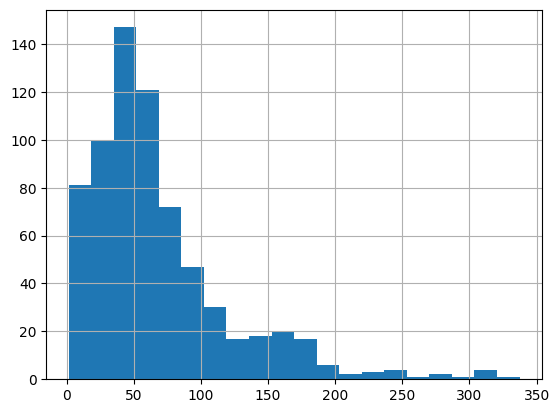

In [24]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~46978.59


<Axes: >

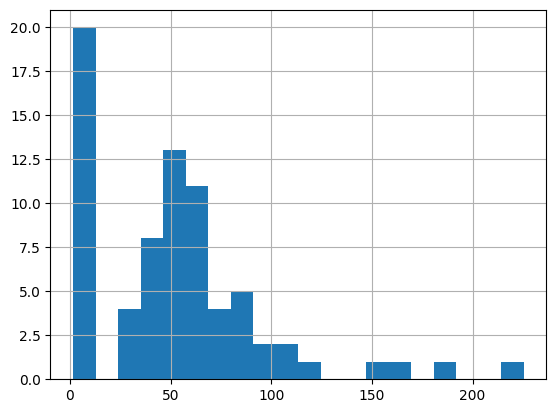

In [25]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='JavaScript Concepts']['age'].hist(bins=20)

# Completely Random Shuffle

In [26]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [27]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [28]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [29]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [30]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [31]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [32]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [33]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [34]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [35]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 694
Total card age: 46978.59


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
35,FSLogix,Redirector Driver:\nA mechanism within FSLogix...,f51a72bfb75cf817d822f0fb50b94a12,337.281877,92.613212,-337.281877,2500.556730,0.089666,27,0,0,-337.281877
36,FSLogix,Profile Container:\nA core FSLogix component t...,b670534e0dff1e6a1580055916917c3e,147.055488,92.613212,-337.281877,2500.556730,0.089666,27,3,0,-147.055488
37,FSLogix,"Cloud Cache uses the concept of a proxy file, ...",78203bab9238f47ee752697bba4135a5,95.374675,92.613212,-337.281877,2500.556730,0.089666,27,6,0,-95.374675
512,FSLogix,Q: What does the FSLogix Profile Container do ...,f91ad9ae4f11b37027a69c4907515a9b,80.591530,92.613212,-337.281877,2500.556730,0.089666,27,9,0,-80.591530
39,FSLogix,"Q: What is FSLogix App Masking, and how does i...",824e92f426fbbd7da3b69be09c0f6647,77.904341,92.613212,-337.281877,2500.556730,0.089666,27,12,0,-77.904341
40,FSLogix,Antivirus Software Exclusions for FSLogix Cont...,69383cd33bba724607ded02ce15b5412,62.144768,92.613212,-337.281877,2500.556730,0.089666,27,15,0,-62.144768
41,FSLogix,FSLogix Agent Log:\nA log file generated by th...,65fdc9d8347dfdb1fb571ffdf5d989b8,50.581711,92.613212,-337.281877,2500.556730,0.089666,27,18,0,-50.581711
42,FSLogix,Data is written to all storage providers regar...,39621ec431c5e31c5e8f49018fe980fe,43.225872,92.613212,-337.281877,2500.556730,0.089666,27,21,0,-43.225872
43,FSLogix,Q: How does FSLogix prevent user profile corru...,961d3a781b14387f9ecc0f0481422529,36.458552,92.613212,-337.281877,2500.556730,0.089666,27,24,0,-36.458552
74,Vocab,Palimpsest\nnoun\nSPA: PAL-imps-est\nIPA: /ˈpæ...,83dd5618c76e96fde6405f55d07dbe7d,308.018313,84.502097,-308.018313,4225.104868,0.089405,50,0,0,-308.018313


## Card Count

In [36]:
# n=4
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [37]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [38]:
existing_cards.head(10)['age'].sum()

np.float64(1238.6371257884102)

In [39]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
35,FSLogix,Redirector Driver:\nA mechanism within FSLogix...,f51a72bfb75cf817d822f0fb50b94a12,337.281877,92.613212,-337.281877,2500.556730,0.089666,27,0,0,-337.281877
74,Vocab,Palimpsest\nnoun\nSPA: PAL-imps-est\nIPA: /ˈpæ...,83dd5618c76e96fde6405f55d07dbe7d,308.018313,84.502097,-308.018313,4225.104868,0.089405,50,0,0,-308.018313
10,C# Basics,What are common libraries and frameworks in C#...,d714cbc1740b344f84ed84278b332f36,308.000290,95.482187,-308.000290,2291.572498,0.665261,24,0,0,-308.000290
91,Python,Q:\nWhat is the primary purpose of exit codes ...,d5ae26a1eb6bf1e733080a8396f21e2d,304.764377,84.173610,-304.764377,4461.201340,0.087567,53,0,0,-304.764377
275,FSLogix,A full VHD(x) clone is performed when Cloud Ca...,71af619ba0f37ffd62aa637176cd6ef4,304.706217,92.613212,-337.281877,2500.556730,0.089666,27,1,1,-304.706217
18,PnP PowerShell,Export-PnPProvisioningTemplate (PnP.PowerShell...,fa28f8230bbc691d7374863ca568f6cc,290.124858,93.435640,-290.124858,4578.346361,0.747311,49,0,0,-290.124858
329,Python,Q:\nHow can you define a custom exception in P...,42a1f83efefd4b56173827e48cae56f3,279.514389,84.173610,-304.764377,4461.201340,0.087567,53,1,1,-279.514389
237,Asynchronous Python,"Thread Pool Executor\nA thread pool executor, ...",102c628cf04ad4661a71d437cd297a11,271.094911,86.705455,-271.094911,2427.752752,0.767636,28,0,0,-271.094911
312,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,269.827065,84.502097,-308.018313,4225.104868,0.089405,50,1,1,-269.827065
259,PnP PowerShell,Invoke-RestMethod Parameters\nKey parameters i...,e6a04d0a76f2a4a9cba720d23ffea2c8,245.018163,93.435640,-290.124858,4578.346361,0.747311,49,1,1,-245.018163


In [40]:
existing_cards['age'].mean()

np.float64(67.69248651011681)